<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
with open('/content/drive/My Drive/DD2424_Project/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)
with open('/content/drive/My Drive/DD2424_Project/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)

testN = testX.shape[0]
testX = testX.reshape((testN, 224, 224, 1))
testX.shape

(231, 224, 224, 1)

In [0]:
dirname = "/content/drive/My Drive/DD2424_Project/split-80-20-bs16-with-augmentation-weights-1-1-8"
filename = "model8-3-augmentation-16-0.90-best-network.hdf5"
print(os.path.join(dirname, filename))
model = keras.models.load_model(os.path.join(dirname, filename))

test_y_pred_m = model.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

print(testX.shape)
print(test_y.shape)
print(test_y_pred_m.shape)
print(test_y_pred8.shape)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Test set")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

/content/drive/My Drive/DD2424_Project/split-80-20-bs16-with-augmentation-weights-1-1-8/model8-3-augmentation-16-0.90-best-network.hdf5
(231, 224, 224, 1)
(231,)
(231, 3)
(231,)
Test set
[[96  2  2]
 [ 8 88  4]
 [ 4  1 26]]
              precision    recall  f1-score   support

           0      0.889     0.960     0.923       100
           1      0.967     0.880     0.921       100
           2      0.812     0.839     0.825        31

    accuracy                          0.909       231
   macro avg      0.889     0.893     0.890       231
weighted avg      0.912     0.909     0.909       231



In [0]:
filename = "/content/drive/My Drive/DD2424_Project/model8-16-0.91.hdf5"
model = keras.models.load_model(filename)
test_y_pred_m = model.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

Confusion matrix:
[[95  5  0]
 [11 89  0]
 [10 13  8]]
              precision    recall  f1-score   support

           0      0.819     0.950     0.880       100
           1      0.832     0.890     0.860       100
           2      1.000     0.258     0.410        31

    accuracy                          0.831       231
   macro avg      0.884     0.699     0.717       231
weighted avg      0.849     0.831     0.808       231



# Grad-CAM visualization

In [0]:
import vis
from vis.utils import utils

# last layer
layer_idx = len(model.layers)-1
print(layer_idx)
#layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[layer_idx].activation = keras.activations.linear
#model = utils.apply_modifications(model)

model.summary()

71
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 112, 112, 64) 3200        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 112, 112, 64) 256         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 112, 112, 64) 0           batch_normalization_44[0][0]     
_________________________________________________________________________________________

Using TensorFlow backend.


In [0]:
!pip install scipy==1.2.0

     |████████████████████████████████| 26.6MB 113kB/s 
ERROR: umap-learn 0.4.2 has requirement scipy>=1.3.1, but you'll have scipy 1.2.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
from vis.visualization import visualize_cam
penultimate_layer_idx = len(model.layers) - 11 # last conv layer

#preds = model.predict(testX)
preds = test_y_pred8

img_idx = 10
grad_top1 = visualize_cam(model, layer_idx, preds[img_idx], testX[img_idx],
                         penultimate_layer_idx  = penultimate_layer_idx,
                         backprop_modifier      = None,
                         grad_modifier          = None)

print(grad_top1.shape)

(224, 224, 3)


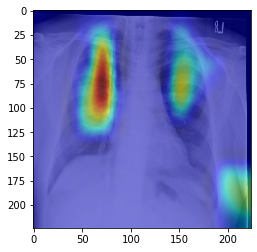

0
0


In [0]:
import cv2 as cv2

def plot_map(grad_top, image, alpha=0.5):
  # change image to match grad_top
  image = 255*image
  image = image.astype('uint8')
  image = np.repeat(image, 3, 2)

  # superimpose the gard_top over image and plot
  final = cv2.addWeighted(grad_top, 0.5, image, 0.5, 0)
  plt.imshow(final)
  plt.show()

plot_map(grad_top1, testX[img_idx], 1)

print(test_y[img_idx])
print(preds[img_idx])

def plot_grad_cam():
  plot_map